## Setting up the environment


In [25]:
import gymnasium as gym
import text_flappy_bird_gym

if __name__ == "__main__":
    env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)

# Implement Q method

In [26]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [33]:
class SARSA:
    def __init__(self, space_size, action_size, gamma=1):
        """
        Calculates optimal policy using in-policy Temporal Difference control
        Evaluates Q-value for (S,A) pairs, using one-step updates.
        """
        # the discount factor
        self.gamma = gamma

        # size of system
        self.space_size = space_size  # as tuple
        self.action_size = action_size

        # where to save returns
        self.Qvalues = np.zeros((*self.space_size, self.action_size))
    
    def get_action_epsilon_greedy(self, s):
        """
        Chooses action at random using an epsilon-greedy policy wrt the current Q(s,a).
        """
        ran = np.random.rand()

        if ran < self.epsilon:
            prob_actions = np.ones(self.action_size) / self.action_size

        else:
            best_value = np.max(self.Qvalues[(*s,)])

            best_actions = self.Qvalues[(*s,)] == best_value

            prob_actions = best_actions / np.sum(best_actions)

        a = np.random.choice(self.action_size, p=prob_actions)
        return a
    
    def single_step_update(self, s, a, r, new_s, new_a, done):
        """
        Uses a single step to update the values, using Temporal Difference for Q values.
        Employs the EXPERIENCED action in the new state  <- Q(S_new, A_new).
        """
        self.et[(*s, a)] += 1

        # If we reached the terminal state
        if done:
            deltaQ = r + 0 - self.Qvalues[(*s, a)]
            self.Qvalues += self.lr_v*deltaQ*self.et

        else:
            deltaQ = (
                r + self.gamma * self.Qvalues[(*new_s, new_a)] - self.Qvalues[(*s, a)])
            
            self.Qvalues += self.lr_v*deltaQ*self.et
            self.et *= self.gamma*self.lambda_
    
    def train(self, n_episodes = 10000, lambda_ = 0, tstar = None, epsilon_0=0.2, k_epsilon = 0, lr_v0=0.15, k_lr = 0):
        """
        This function trains the agent using n_episodes.
        The default parameters use constant learning rate and epsilon (k = 0 in both cases)
        Otherwise a decaying rate is implemented after a starting point t0 (see README for more details)
        Similarly the default implements a TD(0) evaluation procedure (lambda = 0)
        """

        Actions = [i for i in range(self.action_size)]
        self.n_episodes = n_episodes

        # Add the following attributes to the class
        self.performance_traj = np.zeros(n_episodes) # To store cumulative reward at every game
        
        self.et = np.zeros((*self.space_size, self.action_size))
        self.lambda_ = lambda_

        # Parameters for epsilon decay
        self.epsilon_0 = epsilon_0  # Needed to name the plots
        self.epsilon = epsilon_0    # Needed to keep track of current epsilon
        self.k_epsilon = k_epsilon

        # Parameters for learning rate decay
        self.lr_v0 = lr_v0
        self.lr_v = lr_v0
        self.k_lr = k_lr

        if(tstar is None):
            tstar = 2.5 * n_episodes 
        
        count = 0 # counter variable needed to see when to start decaying rates

        # Run over episodes
        for i in range(n_episodes):
            done = False
            s, info = env.reset()
            a = self.get_action_epsilon_greedy(s)
            act = Actions[a]

            while not done:
                count += 1

                # Perform one "step" in the environment
                new_s, r, done, _, info = env.step(act)

                # Keep track of rewards for one episode
                self.performance_traj[i] += r

                # Choose new action index
                new_a = self.get_action_epsilon_greedy(new_s)
                act = Actions[new_a]
                # Single update with (S, A, R', S', A')
                self.single_step_update(s, a, r, new_s, new_a, done)

                if count > tstar:
                    self.epsilon = epsilon_0/(1. + self.k_epsilon*(count - tstar)**1.05)
                    self.lr_v = lr_v0/(1 + self.k_lr*(count - tstar)**0.75)
                
                a = new_a
                s = new_s
    
    def plot_traj(self, cumulative=True, local=False, save = False):

        title = "SARSA"

        plot_indexes = np.arange(0, self.n_episodes + 1, 20, dtype=int)
        plot_indexes[-1] = plot_indexes[-1] - 1

        plt.plot(plot_indexes, self.performance_traj[plot_indexes])

        if cumulative:
            cumulative_mean = np.cumsum(self.performance_traj) / np.arange(
                1, len(self.performance_traj) + 1
            )
            plt.plot(
                plot_indexes, cumulative_mean[plot_indexes], label="Cumulative mean"
            )
        if local:
            window_size = 100
            local_mean_SARSA = np.convolve(
                self.performance_traj, np.ones(window_size) / window_size, mode="valid"
            )
            plt.plot(
                plot_indexes[plot_indexes < local_mean_SARSA.shape[0]],
                local_mean_SARSA[
                    plot_indexes[plot_indexes < local_mean_SARSA.shape[0]]
                ],
                label=" Local Mean",
            )
        plt.xlabel("Episode")
        plt.ylabel("Episode reward")
        plt.legend()
        plt.suptitle(f"{title} control cumulative rewards")
        plt.title(f"e0 = {self.epsilon_0}, k_e = {self.k_epsilon}, lr = {self.lr_v}, k_lr = {self.k_lr}, lambda = {self.lambda_}")

        # SISTEMARE SALVATAGGIO IN CARTELLA GIUSTA
        if save:
            name = "Plots/SARSA_plots/SARSA_lambda_" + str(self.lambda_) + "_k_alpha_" + str(self.k_lr) + "k_epsilon" + str(self.k_epsilon) + ".png"
            plt.savefig(name)

In [34]:
observation_space = (env.observation_space[0].n, env.observation_space[1].n)
SARSA = SARSA(space_size=observation_space, action_size=2, gamma=1)

In [35]:
SARSA.train(n_episodes=10000)

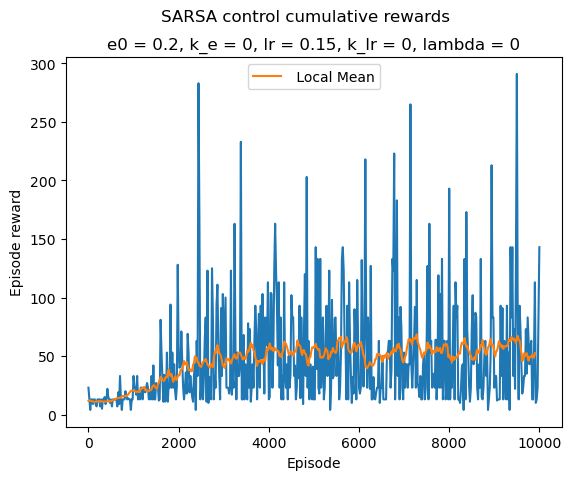

In [36]:
SARSA.plot_traj(cumulative=False, local = True)